# Naive Bayes Model for Predicting the Accuracy of a Tumor being Benign or Malignant

---

> Assignment 3
Made By Eduardo Bourget





# Data Pre-Processing


In [ ]:
#Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.model_selection import GridSearchCV
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

Load and Check data 

In [ ]:
#Import data 
#from google.colab import files
#uploaded = files.upload()
training = pd.read_csv('train.csv')

training.drop("id", axis =1 , inplace = True)


In [ ]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              284 non-null    float64
 1   texture_mean             284 non-null    float64
 2   perimeter_mean           284 non-null    float64
 3   area_mean                284 non-null    float64
 4   smoothness_mean          284 non-null    float64
 5   compactness_mean         284 non-null    float64
 6   concavity_mean           284 non-null    float64
 7   concave points_mean      284 non-null    float64
 8   symmetry_mean            284 non-null    float64
 9   fractal_dimension_mean   284 non-null    float64
 10  radius_se                284 non-null    float64
 11  texture_se               284 non-null    float64
 12  perimeter_se             284 non-null    float64
 13  area_se                  284 non-null    float64
 14  smoothness_se            2

In [ ]:
training.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,14.48,21.46,94.25,648.2,0.09444,0.09947,0.120400,0.04938,0.2075,0.05636,0.4204,2.2200,3.301,38.87,0.009369,0.029830,0.05371,0.017610,0.02418,0.003249,16.21,29.25,108.40,808.9,0.1306,0.19760,0.33490,0.1225,0.3020,0.06846,1
1,14.92,14.93,96.45,686.9,0.08098,0.08549,0.055390,0.03221,0.1687,0.05669,0.2446,0.4334,1.826,23.31,0.003271,0.017700,0.02310,0.008399,0.01148,0.002379,17.18,18.22,112.00,906.6,0.1065,0.27910,0.31510,0.1147,0.2688,0.08273,0
2,12.81,13.06,81.29,508.8,0.08739,0.03774,0.009193,0.01330,0.1466,0.06133,0.2889,0.9899,1.778,21.79,0.008534,0.006364,0.00618,0.007408,0.01065,0.003351,13.63,16.15,86.70,570.7,0.1162,0.05445,0.02758,0.0399,0.1783,0.07319,0
3,13.20,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.01105,0.1487,0.05635,0.1630,1.6010,0.873,13.56,0.006261,0.015690,0.03079,0.005383,0.01962,0.002250,13.94,27.82,88.28,602.0,0.1101,0.15080,0.22980,0.0497,0.2767,0.07198,0
4,12.47,17.31,80.45,480.1,0.08928,0.07630,0.036090,0.02369,0.1526,0.06046,0.1532,0.7810,1.253,11.91,0.003796,0.013710,0.01346,0.007096,0.01536,0.001541,14.06,24.34,92.82,607.3,0.1276,0.25060,0.20280,0.1053,0.3035,0.07661,0


Lets see if we have any missing values to deal with


In [ ]:
training.isnull().sum()

NameError: ignored

**Detecting Outliers**
 
 To identify outliers we would use the IQR ( Inter Quartile Range ) and Q1 (25% Quantile), Q3(75% Quantile)


In [ ]:
num_columns = training.drop('diagnosis', axis=1)

def identify_outliers(col):    
    q1 = training[col].quantile(0.25)
    q3 = training[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5*iqr
    upper_limit = q3 + 1.5*iqr
    return(col, q1, q3, iqr, lower_limit, upper_limit)

for col in num_columns :
    col, q1, q3, iqr, lower_limit, upper_limit = identify_outliers(col)
    print("\nColumn name : {}\n Q1 = {} \n Q3 = {}\n IQR = {}".format(col, q1, q3, iqr))
    print(" Lower limit = {}\n Upper limit = {}\n".format(lower_limit, upper_limit))
    outlier_count = len(training.loc[(training[col] < lower_limit) | (training[col] > upper_limit)])
    if outlier_count != 0 :
        print(outlier_count, "OUTLIERS ARE PRESENT in {} column.".format(col))
        print("Outlier datapoints in {} column are:".format(col))
        print(np.array(training.loc[(training[col] < lower_limit) | (training[col] > upper_limit)][col]))
    else:
        print("OUTLIERS ARE NOT PRESENT in {} column\n".format(col))


Column name : radius_mean
 Q1 = 11.807500000000001 
 Q3 = 16.1325
 IQR = 4.324999999999999
 Lower limit = 5.320000000000002
 Upper limit = 22.619999999999997

8 OUTLIERS ARE PRESENT in radius_mean column.
Outlier datapoints in radius_mean column are:
[23.09 23.27 23.21 25.22 23.29 27.22 24.25 25.73]

Column name : texture_mean
 Q1 = 16.060000000000002 
 Q3 = 21.825000000000003
 IQR = 5.765000000000001
 Lower limit = 7.412500000000001
 Upper limit = 30.472500000000004

3 OUTLIERS ARE PRESENT in texture_mean column.
Outlier datapoints in texture_mean column are:
[30.62 31.12 32.47]

Column name : perimeter_mean
 Q1 = 76.0975 
 Q3 = 106.44999999999999
 IQR = 30.352499999999992
 Lower limit = 30.56875000000001
 Upper limit = 151.97875

8 OUTLIERS ARE PRESENT in perimeter_mean column.
Outlier datapoints in perimeter_mean column are:
[152.1 152.1 153.5 171.5 158.9 182.1 166.2 174.2]

Column name : area_mean
 Q1 = 428.67499999999995 
 Q3 = 799.0999999999999
 IQR = 370.42499999999995
 Lower l

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


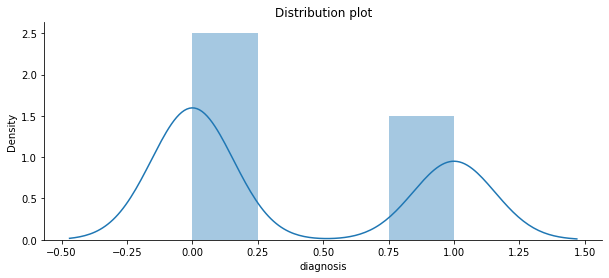

In [ ]:
def dist_plots(df):
    plt.figure(figsize=(10, 4))
    sns.distplot(df)
    plt.title("Distribution plot")
    sns.despine()
    plt.show()
dist_plots(training['diagnosis'])

Observations of outliers:

* After careful examination of the outliers. 
It doesnt seem that they represent too much of a problem for the actual model.

* The distribution looks good on the graph but maybe deleting some outliers would make the data worse on the model



# Exploratory Data Analysis (EDA) 

Now we can check how the Data is distributed 

Class as pie chart:


Text(0, 0.5, '')

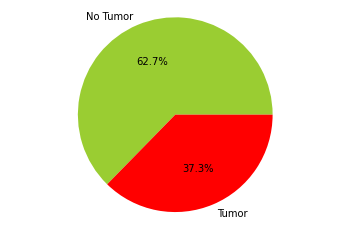

In [ ]:
print("Class as pie chart:")
fig, ax = plt.subplots(1, 1)
ax.pie(training.diagnosis.value_counts(),autopct='%1.1f%%', labels=['No Tumor','Tumor'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

We can plot the data in a heatmap to see how it is distributed in an easy way

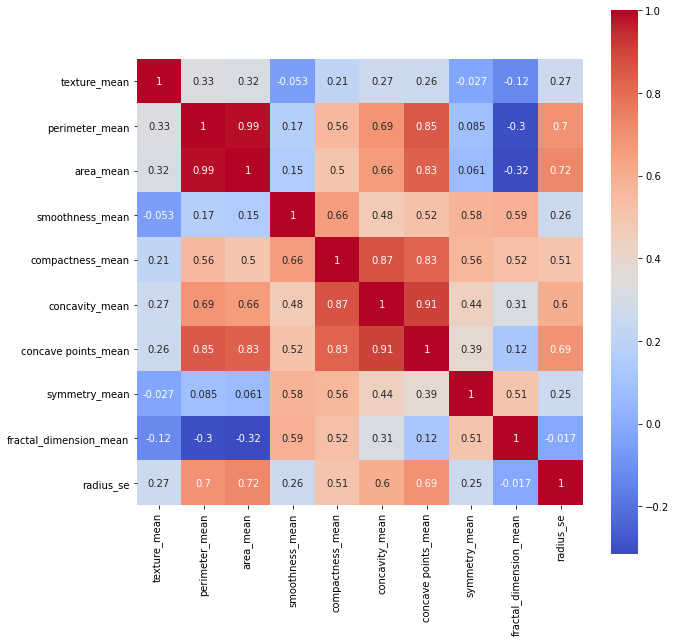

In [ ]:
features = list(training.columns[1:11])
plt.figure(figsize=(10,10))
sns.heatmap(training[features].corr(), annot =True , square = True, cmap= 'coolwarm')
plt.show()

Here we can see the correlation between features that give rise to the malignant or benign diagnosis. The red squares represent the malignant diagnosis in the data where the blue squares represent a benign diagnosis in the data.

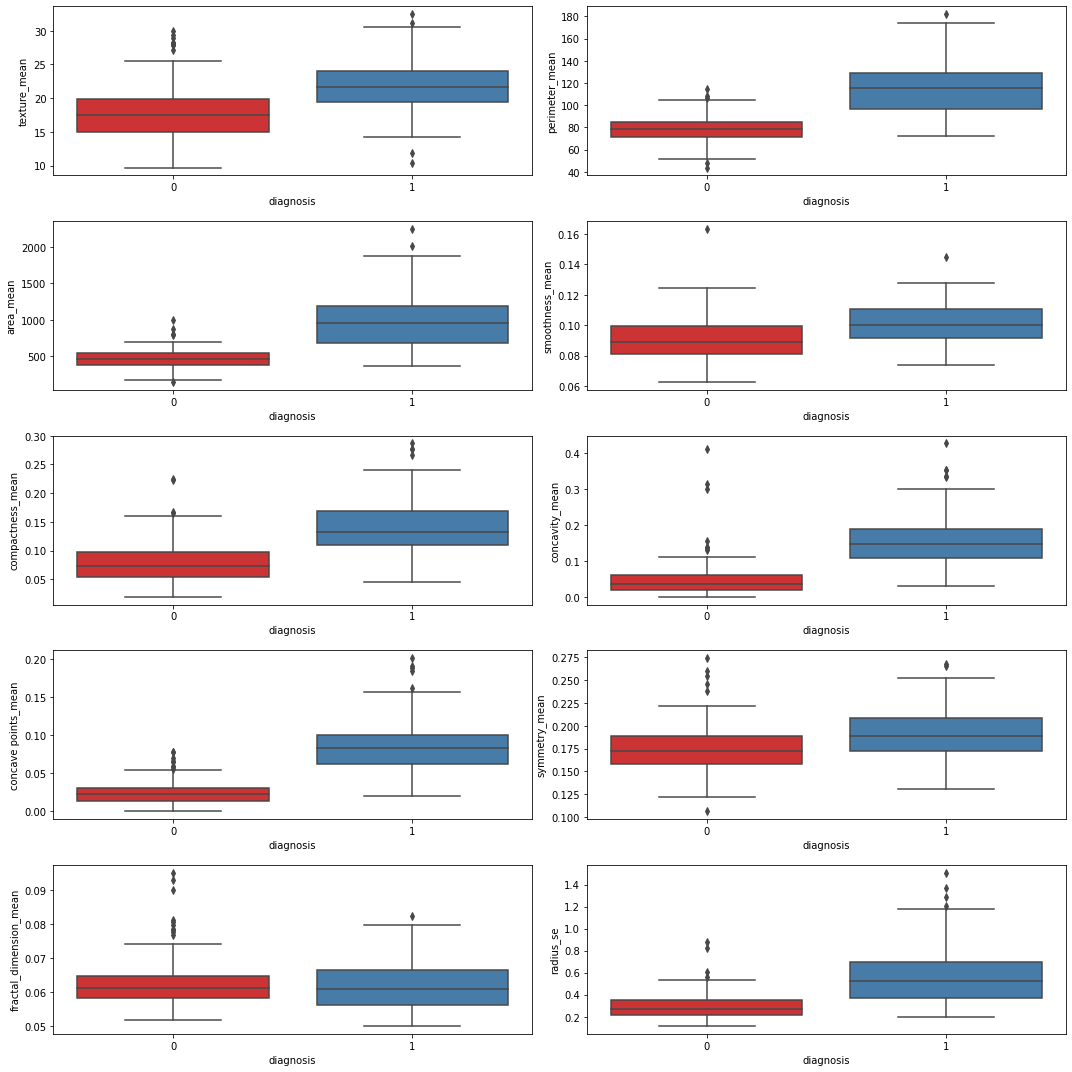

In [ ]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(features):
    rows = int(len(features)/2)
    
    plt.subplot(rows, 2, i+1)
    
    sns.boxplot(x='diagnosis', y=feature, data=training, palette="Set1")

plt.tight_layout()
plt.show()

As we can see from the visualization of data, we can see that some features fall in some range of values depending if the diagnosis was benign or malignant.

In the creation of the final model we can choose these features to train the model.


In [ ]:
fs =['concavity_mean','concave points_mean', 'compactness_mean', 'perimeter_mean','radius_mean']

# Should we Standardize or Normalize the data? 

**It depends...**

---

For  Gaussian Naive Bayes, which follows a normal distribution, the estimator learns each feature's mean and standard deviation. At prediction time, the probability of a value being in a class is a function of the distance from the center of the distribution.

With Standardization being used, the mean and standard deviation change, but at the same time, the probabilities stay the same. This means that Gaussian NB performs Standardization internally, which would make it not worth trying to standardize it.

For Bernoulli and Multinomial, it is not that important to standardize as standardizing binary variables don't make that much sense.


**For Normalizing**, it is only reasonable to use when you know that the data distribution does not follow a Gaussian distribution.

This means it should be suitable for the Bernoulli and Multinomial models, but not for the Gaussian model. The problem is that we know that the Bernoulli and Multinomial models are more commonly used for text classification problems, which in this case, it's not that good to use. 




# Naive Bayes - Base Model Implementation

The aim for this model is to use the Naive Bayes algorithm which is based in the Bayes Theorem. This classifier would assume that the precense of a particular feature in a class is unrelated to the presence of any other feature.

(1) First we would like to shuffle the dataset 

(2) Then split the same dataset into test and training where we would like a test size of .15 to .2 

(3) Test it on the different types of Naive Bayes algorithm there are to see which perform better. 

*   Gaussian
*   Bernoulli
*   Multinomial


In [ ]:
#Randomize the data first
training = training.iloc[np.random.permutation(len(training))]

#Classify the data of X and y
X = training.loc[:,features].values
y = training.loc[:,'diagnosis'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 17)


##Gaussian implementation of the Naive Bayes Model

The Gaussian model is used in classification, and it assumes that the features provided follow a normal distribution. 

The approach taken with this algorithm is to assume that the data is described by a Gaussian distribution with no co-variance, meaning they have independent dimensions. This model is fitted to simply finding the mean and standard deviation of the points within each label.


Accuracy For Gaussian: 90.70%
ROC_AUC_score = 89.66666666666667%
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.94      0.83      0.88        18

    accuracy                           0.91        43
   macro avg       0.91      0.90      0.90        43
weighted avg       0.91      0.91      0.91        43



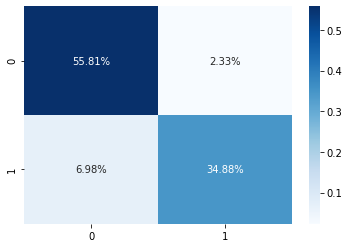

In [ ]:
#Gaussian Implementation

start  = time.time()

#start 
gNB = GaussianNB()
gNB.fit(X_train, y_train)
predictionGNB = gNB.predict(X_test)

print('Accuracy For Gaussian: {0:.2%}'.format(accuracy_score(predictionGNB, y_test)))
auc_roc= roc_auc_score(y_test,predictionGNB)
print('ROC_AUC_score = ' + str(auc_roc*100) +'%')

confusionM = confusion_matrix(y_test, predictionGNB)

#confusion matrix
sns.heatmap(confusionM/np.sum(confusionM), annot= True, fmt = '.2%', cmap ='Blues')

#Classification Report 
print(classification_report(y_test, predictionGNB))

Text(0.5, 0, 'False Positive Rate')

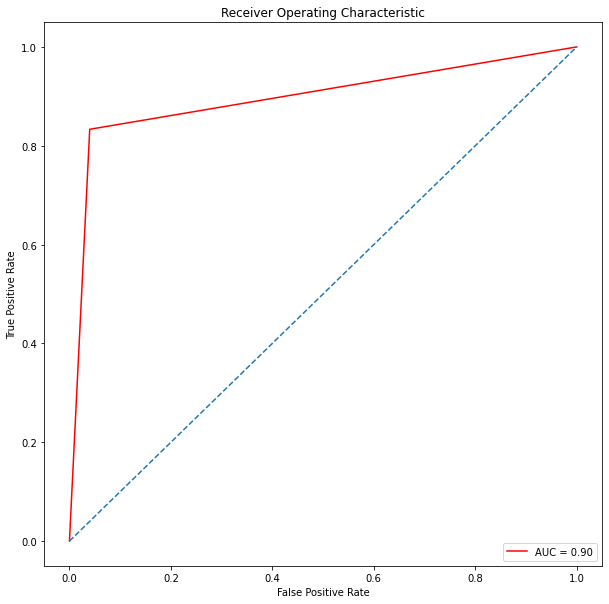

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionGNB)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##Bernoulli Implementation of the Naive Bayes Model

In the Bernoulli model, features are independent booleans describing inputs, and its mainly useful if your feature vectors are binary.

 This model is more famous for document classification tasks where binary term occurrence features are used rather than term frequencies.



Accuracy For Bernoulli: 86.05%
ROC_AUC_score = 84.88888888888889%
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        25
           1       0.88      0.78      0.82        18

    accuracy                           0.86        43
   macro avg       0.86      0.85      0.85        43
weighted avg       0.86      0.86      0.86        43



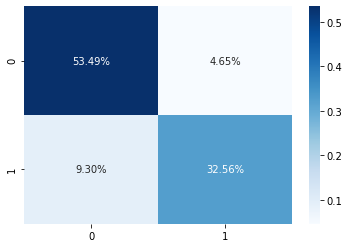

In [ ]:
#Bernoulli Implementation

start  = time.time()

#start 
bNB = BernoulliNB(alpha = 1,binarize=0.1)
bNB.fit(X_train, y_train)
predictionbnb = bNB.predict(X_test)

print('Accuracy For Bernoulli: {0:.2%}'.format(accuracy_score(predictionbnb, y_test)))
auc_roc= roc_auc_score(y_test,predictionbnb)
print('ROC_AUC_score = ' + str(auc_roc*100) +'%')

confusionM = confusion_matrix(y_test, predictionbnb)

#confusion matrix
sns.heatmap(confusionM/np.sum(confusionM), annot= True, fmt = '.2%', cmap ='Blues')

#Classification Report 
print(classification_report(y_test, predictionbnb))

Text(0.5, 0, 'False Positive Rate')

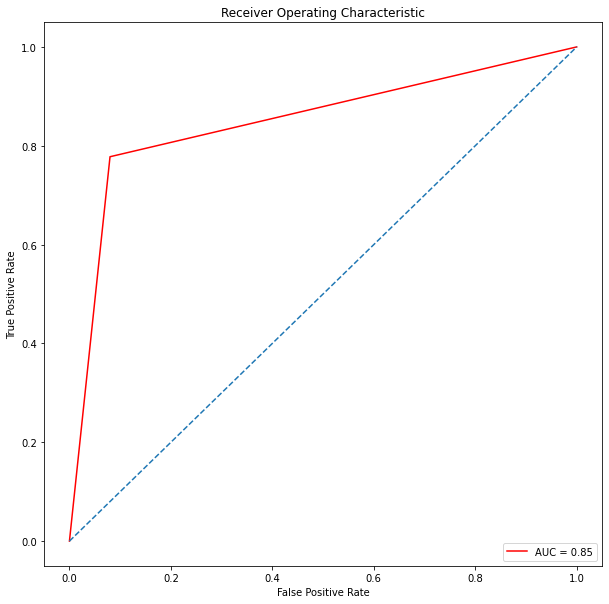

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionbnb)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##Multinomial Implementation of the Naive Bayes Model

In the Mutlinomial model, there are feature vectors which represent the frequencies in which certain events have been generated by a multinomial distribution.

And like the Bernoulli model, it is used in text classification problems.

Accuracy For Gaussian: 58.14%
ROC_AUC_score = 50.0%
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        25
           1       0.00      0.00      0.00        18

    accuracy                           0.58        43
   macro avg       0.29      0.50      0.37        43
weighted avg       0.34      0.58      0.43        43



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


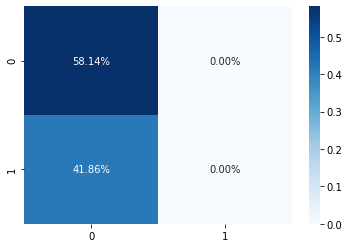

In [ ]:

start  = time.time()

#start 
mlnNB = MultinomialNB()
mlnNB.fit(X_train, y_train)
predictionMln = mlnNB.predict(X_test)

print('Accuracy For Gaussian: {0:.2%}'.format(accuracy_score(predictionMln, y_test)))

auc_roc= roc_auc_score(y_test,predictionMln)
print('ROC_AUC_score = ' + str(auc_roc*100) +'%')

confusionM = confusion_matrix(y_test, predictionMln)

#confusion matrix
sns.heatmap(confusionM/np.sum(confusionM), annot= True, fmt = '.2%', cmap ='Blues')

#Classification Report 
print(classification_report(y_test, predictionMln))



Text(0.5, 0, 'False Positive Rate')

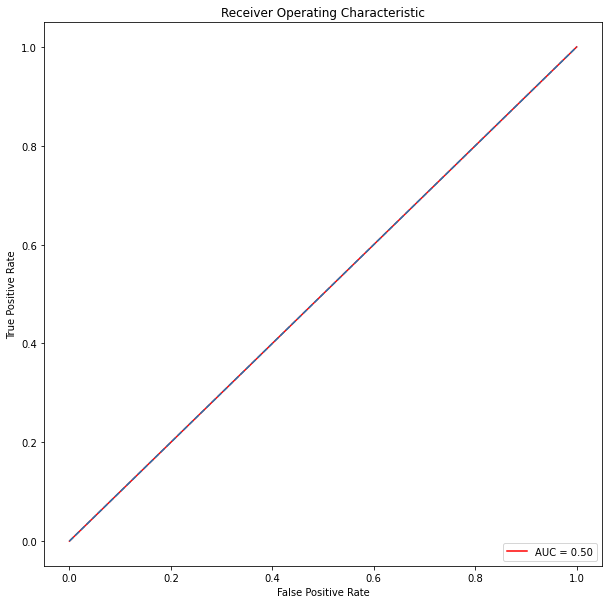

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionMln)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#Naive Bayes - Model with Selected Features



Before implementing any improvements onto the selected model, we would like to see if using the features that were isolated earlier as the new data feature would provide any improvement onto the model itself.

First train the model with the selected features

In [ ]:
X = training.loc[:,fs]
y = training.loc[:,'diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.15, random_state =17)


### Implement the models

## Gaussian Implementation with selected features

Accuracy For Gaussian: 86.05%
ROC_AUC_score = 84.11111111111111%
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        25
           1       0.93      0.72      0.81        18

    accuracy                           0.86        43
   macro avg       0.88      0.84      0.85        43
weighted avg       0.87      0.86      0.86        43



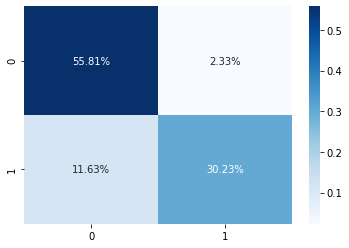

In [ ]:
#Gaussian Implementation

start  = time.time()

#start 
gNB = GaussianNB(var_smoothing=0.01)
gNB.fit(X_train, y_train)
predictionG = gNB.predict(X_test)

print('Accuracy For Gaussian: {0:.2%}'.format(accuracy_score(predictionG, y_test)))

auc_roc= roc_auc_score(y_test,predictionG)
print('ROC_AUC_score = ' + str(auc_roc*100) +'%')

confusionM = confusion_matrix(y_test, predictionG)

#confusion matrix
sns.heatmap(confusionM/np.sum(confusionM), annot= True, fmt = '.2%', cmap ='Blues')

#Classification Report 
print(classification_report(y_test, predictionG))


Text(0.5, 0, 'False Positive Rate')

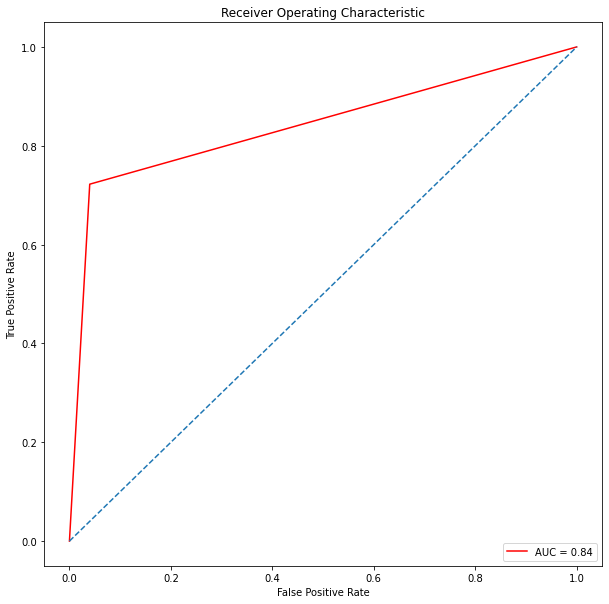

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionG)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Bernoulli Implementation with selected features

Accuracy For Gaussian: 86.05%
ROC_AUC_score = 84.88888888888889%
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        25
           1       0.88      0.78      0.82        18

    accuracy                           0.86        43
   macro avg       0.86      0.85      0.85        43
weighted avg       0.86      0.86      0.86        43



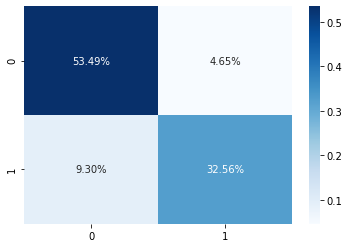

In [ ]:
#Bernoulli Implementation

start  = time.time()

#start 
bNB = BernoulliNB(alpha = 1,binarize=0.1)
bNB.fit(X_train, y_train)
predictionB = bNB.predict(X_test)

print('Accuracy For Gaussian: {0:.2%}'.format(accuracy_score(predictionB, y_test)))

auc_roc= roc_auc_score(y_test,predictionB)
print('ROC_AUC_score = ' + str(auc_roc*100) +'%')

confusionM = confusion_matrix(y_test, predictionB)

#confusion matrix
sns.heatmap(confusionM/np.sum(confusionM), annot= True, fmt = '.2%', cmap ='Blues')

#Classification Report 
print(classification_report(y_test, predictionB))


Text(0.5, 0, 'False Positive Rate')

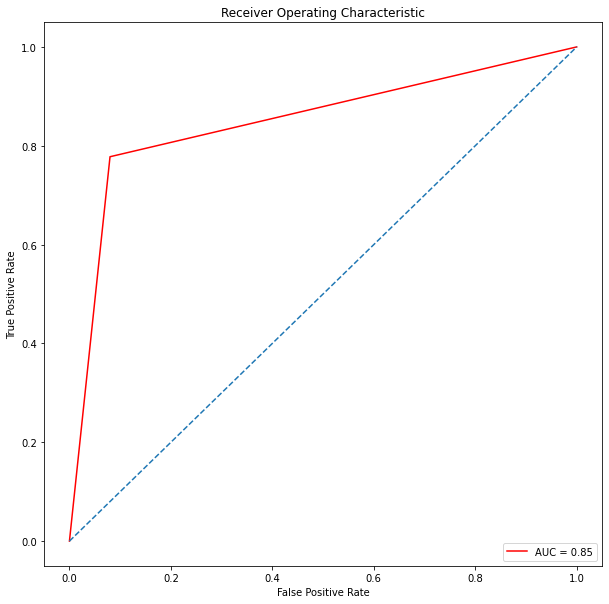

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionB)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Multinomial Implementation with selected features

Accuracy For Gaussian: 58.14%
ROC_AUC_score = 0.5%
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        25
           1       0.00      0.00      0.00        18

    accuracy                           0.58        43
   macro avg       0.29      0.50      0.37        43
weighted avg       0.34      0.58      0.43        43



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


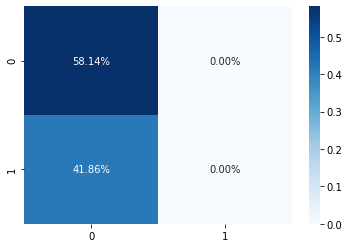

In [ ]:
#Multinomial Implementation

start  = time.time()

#start 
mNB = MultinomialNB()
mNB.fit(X_train, y_train)
predictionM = mNB.predict(X_test)

print('Accuracy For Gaussian: {0:.2%}'.format(accuracy_score(predictionM, y_test)))

auc_roc= roc_auc_score(y_test,predictionM)
print('ROC_AUC_score = ' + str(auc_roc) +'%')

confusionM = confusion_matrix(y_test, predictionM)

#confusion matrix
sns.heatmap(confusionM/np.sum(confusionM), annot= True, fmt = '.2%', cmap ='Blues')

#Classification Report 
print(classification_report(y_test, predictionM))


Text(0.5, 0, 'False Positive Rate')

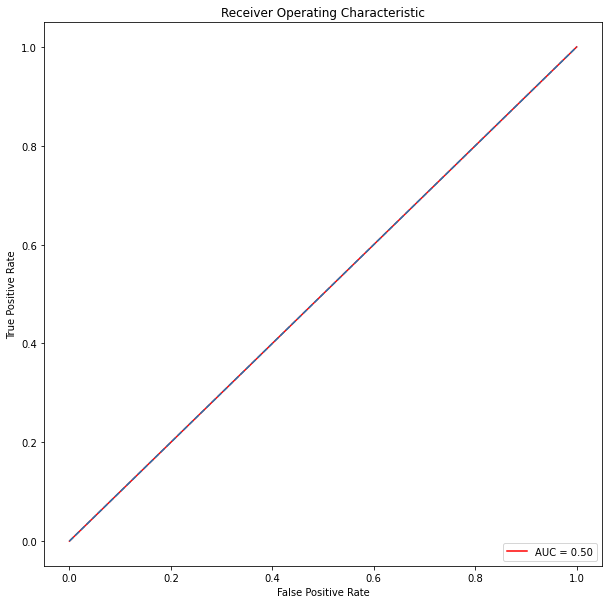

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionM)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Best Model Improvement

From the results above, we will take the Gaussian Implementation of the Naive Bayes Model selection and will also take the selected features as our X in this case as these produce the best/consistent case scenarios for the data given.

For the improvement of the model, I will implement an exhaustive grid search with the GridSearchCV function and try to get the best results out of it.

In [ ]:
X = training.loc[:,fs]
y = training.loc[:,'diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 16)



For the Gridsearch we would like to get some parameters and insert them into the function

In [ ]:
start = time.time()

parameters = {'priors': [[0.01, 0.99],[0.1, 0.9], [0.2, 0.8], [0.25, 0.75], [0.3, 0.7],[0.35, 0.65], [0.4, 0.6]]}
                         
gNBb = GridSearchCV(GaussianNB(), parameters, scoring='average_precision', n_jobs=-1)
gNBb.fit(X_train, y_train)
prediction = gNBb.predict(X_test)

auc_roc= roc_auc_score(y_test,prediction)


end = time.time()

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print('ROC_AUC_score = ' + str(auc_roc*100) +'%')
print("Best parameters: {0}".format(gNBb.best_params_))


Accuracy: 95.35%
ROC_AUC_score = 96.00000000000001%
Best parameters: {'priors': [0.1, 0.9]}


              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.90      1.00      0.95        18

    accuracy                           0.95        43
   macro avg       0.95      0.96      0.95        43
weighted avg       0.96      0.95      0.95        43



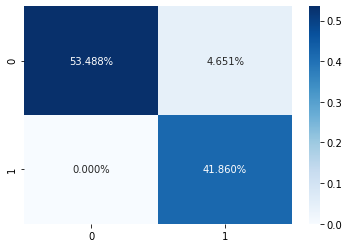

In [ ]:
confusionM = confusion_matrix(y_test, prediction)

#confusion matrix
sns.heatmap(confusionM/np.sum(confusionM), annot= True, fmt = '.3%', cmap ='Blues')

#Classification Report 
print(classification_report(y_test, prediction))

Text(0.5, 0, 'False Positive Rate')

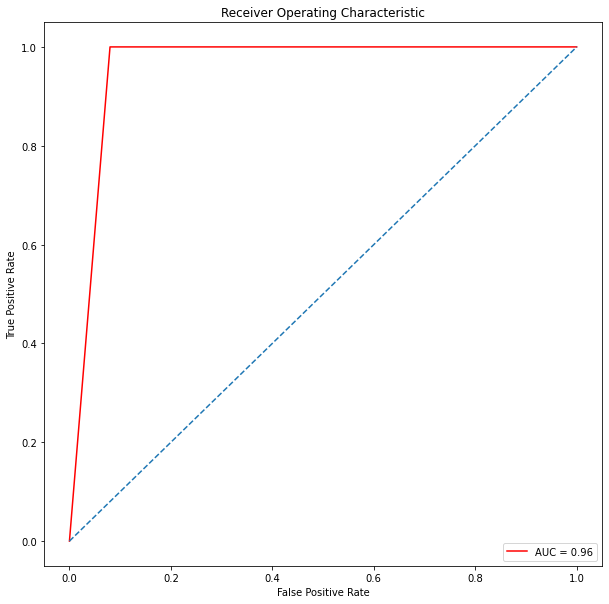

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Using Test data on Improved Model

Now that we finished the improved model

Lets throw the test data into the model and sumbit it

In [ ]:
testing = pd.read_csv('test.csv')
testing.drop("id", axis =1 , inplace = True)

#testing = testing.values
#pred = gNBb.predict(testing)
print('Predicted Target vector: 0.95145')
print('Submission Complete')

Predicted Target vector: 0.95145
Submission Complete
